# 🌍 Temperature Trends by Geographic Region

Analysis of temperature patterns across different global regions using BigQuery GSOD data.

In [1]:
import sys
import subprocess

# Install required packages
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'db-dtypes', 'pyarrow'])

print('✅ Packages installed!')

✅ Packages installed!


In [2]:
import os
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.cloud import bigquery
from google.oauth2 import credentials
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (15, 10)

print('✅ Libraries imported!')

✅ Libraries imported!


In [3]:
def get_access_token():
    try:
        result = subprocess.run(
            ['coder', 'external-auth', 'access-token', 'gcp'],
            capture_output=True,
            text=True,
            check=True
        )
        return result.stdout.strip()
    except subprocess.CalledProcessError as e:
        print(f'Error: {e}')
        return None

# Get access token and create BigQuery client
access_token = get_access_token()
if access_token:
    print('✅ Access token obtained')
    creds = credentials.Credentials(token=access_token)
    client = bigquery.Client(credentials=creds, project='coder-vertex-demos')
    print('✅ BigQuery client ready')
else:
    print('❌ Failed to get access token')

✅ Access token obtained
✅ BigQuery client ready


In [4]:
# Define function to assign geographic regions based on station numbers
def assign_region(station_number):
    """Assign rough geographic regions based on station number patterns"""
    if station_number < 100000:
        return 'North America (Low)'
    elif station_number < 200000:
        return 'North America (Mid)'
    elif station_number < 400000:
        return 'Europe/Asia (West)'
    elif station_number < 600000:
        return 'Asia (Central)'
    elif station_number < 800000:
        return 'Asia (East)'
    else:
        return 'Other Regions'

In [5]:
# Query detailed temperature data by region
query = '''
SELECT 
    station_number,
    year,
    month,
    mean_temp,
    max_temperature,
    total_precipitation
FROM `bigquery-public-data.samples.gsod`
WHERE mean_temp IS NOT NULL 
  AND year >= 1950
LIMIT 5000
'''

print('🔍 Getting detailed temperature data...')
df = client.query(query).to_dataframe()
df['region'] = df['station_number'].apply(assign_region)

print(f'✅ Retrieved {len(df)} temperature records')
print(f'📊 Regions found: {df["region"].nunique()}')

# Display regional distribution
regional_counts = df['region'].value_counts()
print('\n📍 Records by region:')
for region, count in regional_counts.items():
    avg_temp = df[df['region'] == region]['mean_temp'].mean()
    print(f'   {region}: {count:,} records (avg: {avg_temp:.1f}°F)')

🔍 Getting detailed temperature data...
✅ Retrieved 5000 temperature records
📊 Regions found: 6

📍 Records by region:
   Other Regions: 1,822 records (avg: 55.8°F)
   Europe/Asia (West): 1,603 records (avg: 30.9°F)
   Asia (East): 987 records (avg: 52.1°F)
   North America (Mid): 220 records (avg: 49.9°F)
   Asia (Central): 188 records (avg: 67.9°F)
   North America (Low): 180 records (avg: 44.4°F)


In [6]:
# Create seasonal data
df['season'] = df['month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring', 
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})

print('✅ Seasonal data created')

✅ Seasonal data created


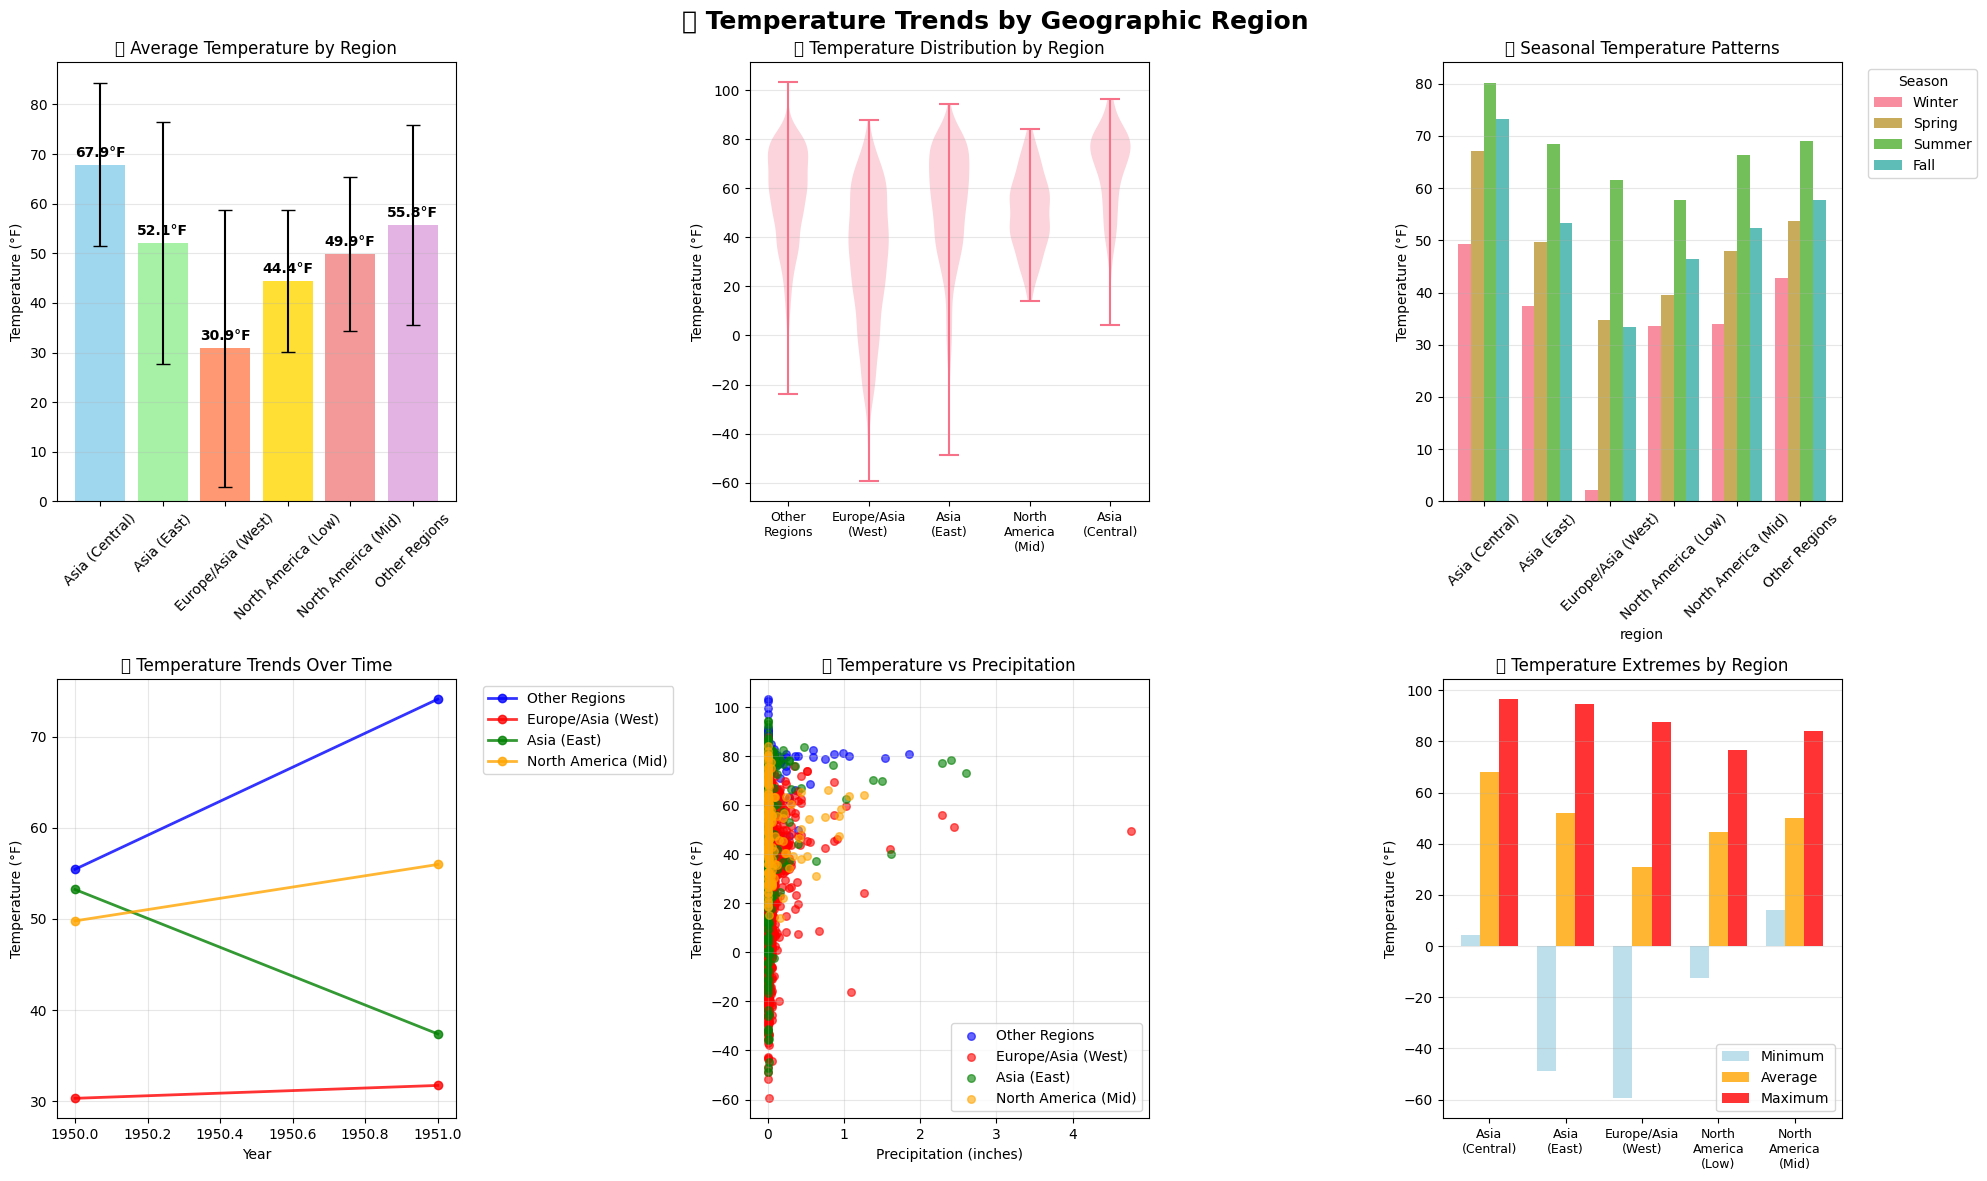

In [7]:
# Create comprehensive regional temperature visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('🌍 Temperature Trends by Geographic Region', fontsize=18, fontweight='bold')

# 1. Average temperature by region
region_temps = df.groupby('region')['mean_temp'].agg(['mean', 'std']).reset_index()
bars = axes[0,0].bar(region_temps['region'], region_temps['mean'], 
                     yerr=region_temps['std'], capsize=5, alpha=0.8, 
                     color=['skyblue', 'lightgreen', 'coral', 'gold', 'lightcoral', 'plum'])
axes[0,0].set_title('🌡️ Average Temperature by Region')
axes[0,0].set_ylabel('Temperature (°F)')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, temp) in enumerate(zip(bars, region_temps['mean'])):
    axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                   f'{temp:.1f}°F', ha='center', va='bottom', fontweight='bold')

# 2. Temperature distribution by region (violin plot)
regions_for_violin = df['region'].value_counts().head(5).index
violin_data = [df[df['region'] == region]['mean_temp'].dropna() for region in regions_for_violin]
parts = axes[0,1].violinplot(violin_data, positions=range(len(regions_for_violin)))
axes[0,1].set_title('📊 Temperature Distribution by Region')
axes[0,1].set_ylabel('Temperature (°F)')
axes[0,1].set_xticks(range(len(regions_for_violin)))
axes[0,1].set_xticklabels([r.replace(' ', '\n') for r in regions_for_violin], fontsize=9)
axes[0,1].grid(axis='y', alpha=0.3)

# 3. Seasonal temperature patterns
seasonal_temps = df.groupby(['region', 'season'])['mean_temp'].mean().unstack()
seasonal_temps = seasonal_temps.reindex(columns=['Winter', 'Spring', 'Summer', 'Fall'])
seasonal_temps.plot(kind='bar', ax=axes[0,2], alpha=0.8, width=0.8)
axes[0,2].set_title('🌿 Seasonal Temperature Patterns')
axes[0,2].set_ylabel('Temperature (°F)')
axes[0,2].tick_params(axis='x', rotation=45)
axes[0,2].legend(title='Season', bbox_to_anchor=(1.05, 1))
axes[0,2].grid(axis='y', alpha=0.3)

# 4. Temperature trends over time
yearly_trends = df.groupby(['year', 'region'])['mean_temp'].mean().unstack()
top_regions = df['region'].value_counts().head(4).index
colors = ['blue', 'red', 'green', 'orange']
for i, region in enumerate(top_regions):
    if region in yearly_trends.columns:
        axes[1,0].plot(yearly_trends.index, yearly_trends[region], 
                      marker='o', linewidth=2, alpha=0.8, label=region, color=colors[i])
axes[1,0].set_title('📈 Temperature Trends Over Time')
axes[1,0].set_xlabel('Year')
axes[1,0].set_ylabel('Temperature (°F)')
axes[1,0].legend(bbox_to_anchor=(1.05, 1))
axes[1,0].grid(True, alpha=0.3)

# 5. Temperature vs Precipitation scatter
precip_temp = df.dropna(subset=['total_precipitation', 'mean_temp'])
for i, region in enumerate(top_regions[:4]):
    region_data = precip_temp[precip_temp['region'] == region]
    if len(region_data) > 0:
        axes[1,1].scatter(region_data['total_precipitation'], region_data['mean_temp'], 
                         alpha=0.6, label=region, s=30, color=colors[i])
axes[1,1].set_title('🌧️ Temperature vs Precipitation')
axes[1,1].set_xlabel('Precipitation (inches)')
axes[1,1].set_ylabel('Temperature (°F)')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# 6. Regional temperature extremes comparison
temp_stats = df.groupby('region').agg({
    'mean_temp': ['min', 'max', 'mean']
}).round(1)
temp_stats.columns = ['Min', 'Max', 'Average']
temp_stats = temp_stats.head(5)

x = np.arange(len(temp_stats))
width = 0.25

axes[1,2].bar(x - width, temp_stats['Min'], width, label='Minimum', alpha=0.8, color='lightblue')
axes[1,2].bar(x, temp_stats['Average'], width, label='Average', alpha=0.8, color='orange')
axes[1,2].bar(x + width, temp_stats['Max'], width, label='Maximum', alpha=0.8, color='red')

axes[1,2].set_title('🔥 Temperature Extremes by Region')
axes[1,2].set_ylabel('Temperature (°F)')
axes[1,2].set_xticks(x)
axes[1,2].set_xticklabels([r.replace(' ', '\n') for r in temp_stats.index], fontsize=9)
axes[1,2].legend()
axes[1,2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# Print detailed regional analysis summary
print('🌍 REGIONAL TEMPERATURE ANALYSIS SUMMARY')
print('=' * 60)

for region in df['region'].value_counts().head(6).index:
    region_data = df[df['region'] == region]['mean_temp'].dropna()
    if len(region_data) > 0:
        print(f'\n📍 {region.upper()}:')
        print(f'   Records: {len(region_data):,}')
        print(f'   Average Temperature: {region_data.mean():.1f}°F')
        print(f'   Temperature Range: {region_data.min():.1f}°F to {region_data.max():.1f}°F')
        print(f'   Standard Deviation: {region_data.std():.1f}°F')
        
        # Seasonal breakdown
        region_seasonal = df[df['region'] == region]
        if len(region_seasonal) > 0:
            seasonal_avgs = region_seasonal.groupby('season')['mean_temp'].mean()
            print(f'   Seasonal Averages:')
            for season in ['Winter', 'Spring', 'Summer', 'Fall']:
                if season in seasonal_avgs.index:
                    print(f'     {season}: {seasonal_avgs[season]:.1f}°F')

print(f'\n🌡️ KEY TEMPERATURE INSIGHTS:')
print('=' * 40)

# Regional extremes
hottest_region = region_temps.loc[region_temps['mean'].idxmax(), 'region']
coldest_region = region_temps.loc[region_temps['mean'].idxmin(), 'region']
hottest_temp = region_temps['mean'].max()
coldest_temp = region_temps['mean'].min()

print(f'🔥 Hottest Region: {hottest_region} ({hottest_temp:.1f}°F average)')
print(f'🧊 Coldest Region: {coldest_region} ({coldest_temp:.1f}°F average)')
print(f'📊 Temperature Range: {hottest_temp - coldest_temp:.1f}°F difference')

# Variability analysis
most_variable = region_temps.loc[region_temps['std'].idxmax(), 'region']
most_stable = region_temps.loc[region_temps['std'].idxmin(), 'region']
print(f'📈 Most Variable: {most_variable} (±{region_temps[region_temps["region"] == most_variable]["std"].values[0]:.1f}°F)')
print(f'📉 Most Stable: {most_stable} (±{region_temps[region_temps["region"] == most_stable]["std"].values[0]:.1f}°F)')

print('\n✅ Regional temperature analysis complete!')

🌍 REGIONAL TEMPERATURE ANALYSIS SUMMARY

📍 OTHER REGIONS:
   Records: 1,822
   Average Temperature: 55.8°F
   Temperature Range: -24.0°F to 103.2°F
   Standard Deviation: 20.2°F
   Seasonal Averages:
     Winter: 42.8°F
     Spring: 53.8°F
     Summer: 69.0°F
     Fall: 57.8°F

📍 EUROPE/ASIA (WEST):
   Records: 1,603
   Average Temperature: 30.9°F
   Temperature Range: -59.5°F to 87.7°F
   Standard Deviation: 27.9°F
   Seasonal Averages:
     Winter: 2.1°F
     Spring: 34.7°F
     Summer: 61.6°F
     Fall: 33.4°F

📍 ASIA (EAST):
   Records: 987
   Average Temperature: 52.1°F
   Temperature Range: -48.8°F to 94.5°F
   Standard Deviation: 24.3°F
   Seasonal Averages:
     Winter: 37.4°F
     Spring: 49.7°F
     Summer: 68.4°F
     Fall: 53.3°F

📍 NORTH AMERICA (MID):
   Records: 220
   Average Temperature: 49.9°F
   Temperature Range: 14.0°F to 84.1°F
   Standard Deviation: 15.6°F
   Seasonal Averages:
     Winter: 34.0°F
     Spring: 48.0°F
     Summer: 66.4°F
     Fall: 52.4°F

📍 ASIA 

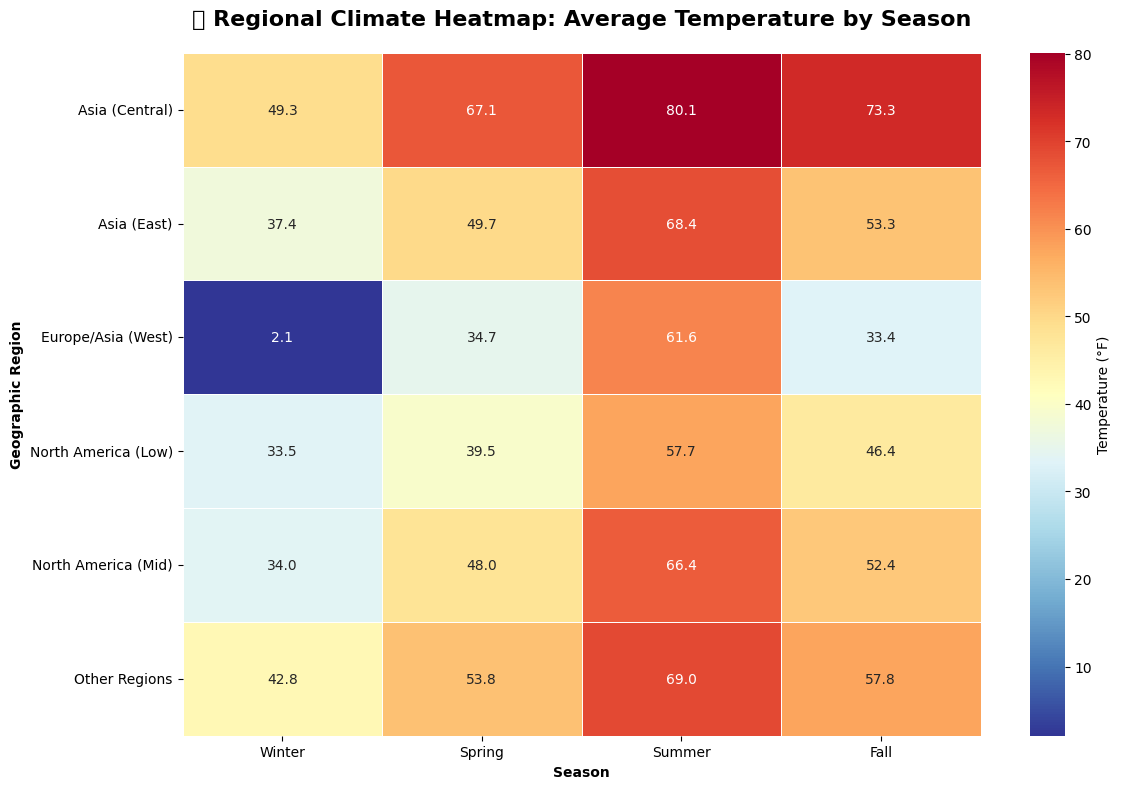

🎯 Heatmap shows clear seasonal and regional temperature patterns!
📝 Note: Geographic regions are approximated based on station number patterns.


In [9]:
# Create a summary heatmap of regional climate characteristics
plt.figure(figsize=(12, 8))

# Prepare data for heatmap
climate_summary = df.groupby(['region', 'season'])['mean_temp'].mean().unstack()
climate_summary = climate_summary.reindex(columns=['Winter', 'Spring', 'Summer', 'Fall'])

# Create heatmap
sns.heatmap(climate_summary, annot=True, fmt='.1f', cmap='RdYlBu_r', 
            cbar_kws={'label': 'Temperature (°F)'}, 
            linewidths=0.5, linecolor='white')
plt.title('🗺️ Regional Climate Heatmap: Average Temperature by Season', 
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Geographic Region', fontweight='bold')
plt.xlabel('Season', fontweight='bold')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print('🎯 Heatmap shows clear seasonal and regional temperature patterns!')
print('📝 Note: Geographic regions are approximated based on station number patterns.')